In this problem you, can simulate a simplified airport security system at a busy airport. Passengers arrive
according to a Poisson distribution with λ1 = 5 per minute (i.e., mean interarrival rate \mu_1 = 0.2 minutes)
to the ID/boarding-pass check queue, where there are several servers who each have exponential
service time with mean rate \mu_2 = 0.75 minutes. Hint: model them as one block that has more than one
resource. After that, the passengers are assigned to the shortest of the several personal-check queues,
where they go through the personal scanner (time is uniformly distributed between 0.5 minutes and 1
minute). 

Use the Arena software (PC users) or Python with SimPy (PC or Mac users) to build a simulation of the
system, and then vary the number of ID/boarding-pass checkers and personal-check queues to
determine how many are needed to keep average wait times below 15 minutes.

In [1]:
#Import relevant libraries
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Build the airport class. This follows the carwash example.
class airport(object):
    
    #Initialize the airport object (copying the carwash example)
    def __init__(self, env, num_bpcheck, num_pcscanner):
        #Need our environment
        self.env = env
        #Define the number of boarding-pass checks as a resource
        self.bpchecks = simpy.Resource(env, num_bpcheck)
        #And define the number of personal scanners
        self.pcscanners = simpy.Resource(env, num_pcscanner)
        
    #The check process at the boarding pass check, once they are free. Basically feed a passenger and a premade length of the check
    def check_bp(self, passenger, check_time):
        #Kick them out once finished
        yield self.env.timeout(check_time)
    
    #Same process for the personal scanner line     
    def check_ps(self, passenger, scan_time):
        yield self.env.timeout(scan_time)
        
#Define our passengers       
def passenger(env, name, ap):
    #Grab their arrival time
    arr = env.now
    #print('%s arrives at %f' % (name, env.now))
    
    #Request a boarding-pass check
    with ap.bpchecks.request() as request:
        yield request
        
        #Use numpy to pick the length of time their check will take and feed it into the process
        check_time = np.random.exponential(scale=0.75)
        yield env.process(ap.check_bp(name, check_time))
        
        #Calculate how long they waited to be checked, not including the time once they were helped
        bpwait = round(env.now - arr - check_time, 5)
        bpout = env.now
        
    #Request a personal scanner line
    with ap.pcscanners.request() as pcreq:
        yield pcreq
        
        #Now pick the length of time the scan will take and feed it into process
        scan_time = np.random.uniform(low=0.5, high=1.0)
        yield env.process(ap.check_ps(name, scan_time))
        
        #Calculate the wait time since they left the boarding-pass line
        pswait = round(env.now - scan_time - bpout, 5)
        #print('%s is done at %s' % (name, env.now))
    
    #print(name, 'total wait:', pswait + bpwait)
    #Append a 5 object tuple to our data for this simulation for analysis
    data.append((name, arr, bpwait, pswait, pswait+bpwait))    

#Define our initial setup
def setup(env, num_bpcheck, num_pcscanner):
    #Build the airport
    air = airport(env, num_bpcheck, num_pcscanner)
    #Make our first passenger
    i=0
    env.process(passenger(env, 'P%d' % i, air))
    #Continue sending passengers based on a Poisson distribution with mean interarrival rate 0.2/minute
    while True:
        yield env.timeout(np.random.poisson(lam=0.2))
        i += 1
        env.process(passenger(env, 'P%d' % i, air))

In [3]:
#Begin the simulation and initialize the data and environment
pairs = [1,2,3,4]
average_waits = [0]*len(pairs)
for k,n in enumerate(pairs):
    SIM_NUMBER = 50
    n_avgs = []
    for i in range(SIM_NUMBER):
        #print('Airport Simulation %s' % (i))
        env = simpy.Environment()
        data = []
        env.process(setup(env, n, n))
        #SIM is the number of simulated minutes. Using 1440 for a full simulated day.
        SIM = 1440
        env.run(until=SIM)
        names = [t[0] for t in data]
        arrivals = [t[1] for t in data]
        wait_bps = [t[2] for t in data]
        wait_pss = [t[3] for t in data]
        total_waits = [t[4] for t in data]
        columns = ['Name', 'Arrival', 'BPWait', 'PSWait', 'TotalWait']
        obs = [names, arrivals, wait_bps, wait_pss, total_waits]
        dfd = dict(zip(columns, obs))
        df = pd.DataFrame(data = dfd)
        n_avgs.append(np.mean(df['TotalWait']))
    average_waits[k] = n_avgs

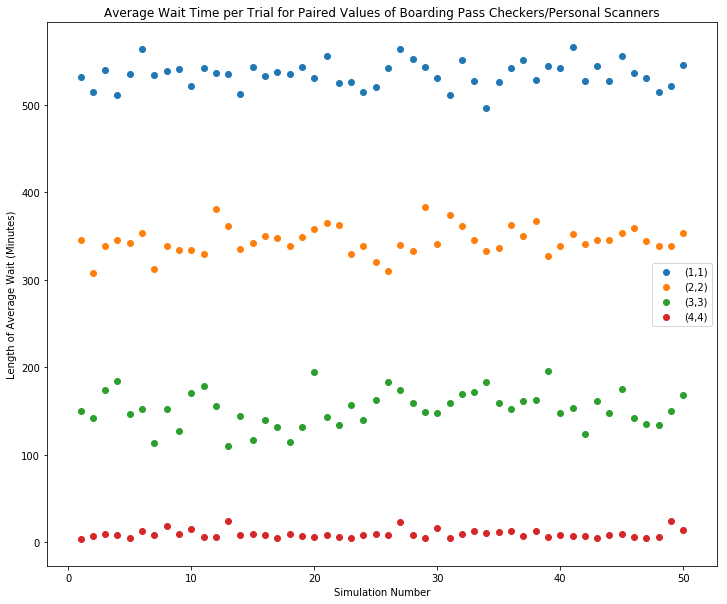

In [4]:
#Now plot all the average waits for each trial. 
plt.figure(figsize=(12,10))
plt.scatter(x=range(1,51), y=average_waits[0])
plt.scatter(x=range(1,51), y=average_waits[1])
plt.scatter(x=range(1,51), y=average_waits[2])
plt.scatter(x=range(1,51), y=average_waits[3])
plt.legend(['(1,1)', '(2,2)', '(3,3)', '(4,4)'])
plt.title('Average Wait Time per Trial for Paired Values of Boarding Pass Checkers/Personal Scanners')
plt.xlabel('Simulation Number')
plt.ylabel('Length of Average Wait (Minutes)');

So we see that even with 3 of each, the wait times are far too high. At 4 of each we are clearly below the 15 minute average threshold, but do we really need 4 of each? Or can we get away with fewer at one of the stations. Now we can run some trials, holding one side constant at 3 and iterating the number of the other, and repeat for both.

In [5]:
n_personal = [3,4,5,6]
average_waits_personaltrial = [0]*len(n_personal)
for k,n in enumerate(n_personal):
    SIM_NUMBER = 50
    n_avgs = []
    for i in range(SIM_NUMBER):
        #print('Airport Simulation %s' % (i))
        env = simpy.Environment()
        data = []
        env.process(setup(env, 3, n))
        #SIM is the number of simulated minutes. Using 1440 for a full simulated day.
        SIM = 1440
        env.run(until=SIM)
        names = [t[0] for t in data]
        arrivals = [t[1] for t in data]
        wait_bps = [t[2] for t in data]
        wait_pss = [t[3] for t in data]
        total_waits = [t[4] for t in data]
        columns = ['Name', 'Arrival', 'BPWait', 'PSWait', 'TotalWait']
        obs = [names, arrivals, wait_bps, wait_pss, total_waits]
        dfd = dict(zip(columns, obs))
        df = pd.DataFrame(data = dfd)
        n_avgs.append(np.mean(df['TotalWait']))
    average_waits_personaltrial[k] = n_avgs

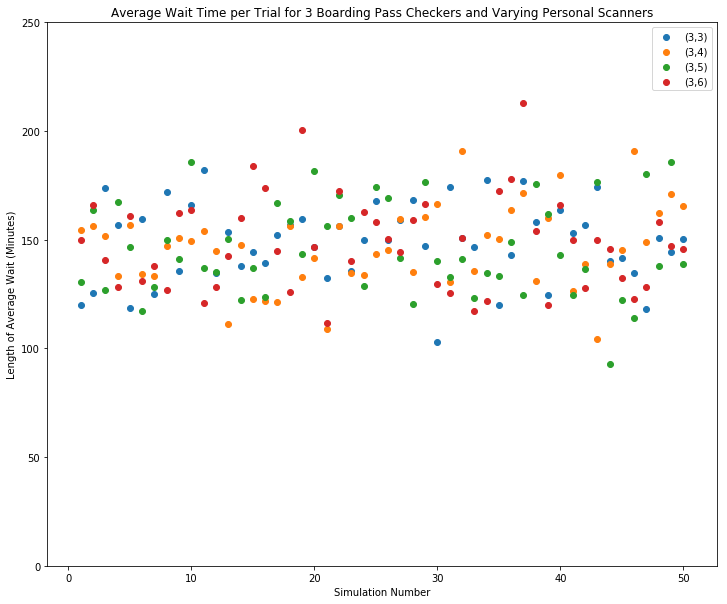

In [6]:
#Now plot all the average waits for each trial. 
plt.figure(figsize=(12,10))
plt.scatter(x=range(1,51), y=average_waits_personaltrial[0])
plt.scatter(x=range(1,51), y=average_waits_personaltrial[1])
plt.scatter(x=range(1,51), y=average_waits_personaltrial[2])
plt.scatter(x=range(1,51), y=average_waits_personaltrial[3])
plt.legend(['(3,3)', '(3,4)', '(3,5)', '(3,6)'])
plt.ylim((0,250))
plt.title('Average Wait Time per Trial for 3 Boarding Pass Checkers and Varying Personal Scanners')
plt.xlabel('Simulation Number')
plt.ylabel('Length of Average Wait (Minutes)');

This is not very insightful...however we can see that at no point did the average wait time for any trial drop below the 15 minutes. Clearly the limiting factor is our number of boarding pass checkers. We can repeat the iteration but keep the number of scanners at 3, and increase the number of boarding pass checkers.

In [7]:
n_bp = [3,4,5,6]
average_waits_bptrial = [0]*len(n_bp)
for k,n in enumerate(n_bp):
    SIM_NUMBER = 50
    n_avgs = []
    for i in range(SIM_NUMBER):
        #print('Airport Simulation %s' % (i))
        env = simpy.Environment()
        data = []
        env.process(setup(env, n, 3))
        #SIM is the number of simulated minutes. Using 1440 for a full simulated day.
        SIM = 1440
        env.run(until=SIM)
        names = [t[0] for t in data]
        arrivals = [t[1] for t in data]
        wait_bps = [t[2] for t in data]
        wait_pss = [t[3] for t in data]
        total_waits = [t[4] for t in data]
        columns = ['Name', 'Arrival', 'BPWait', 'PSWait', 'TotalWait']
        obs = [names, arrivals, wait_bps, wait_pss, total_waits]
        dfd = dict(zip(columns, obs))
        df = pd.DataFrame(data = dfd)
        n_avgs.append(np.mean(df['TotalWait']))
    average_waits_bptrial[k] = n_avgs

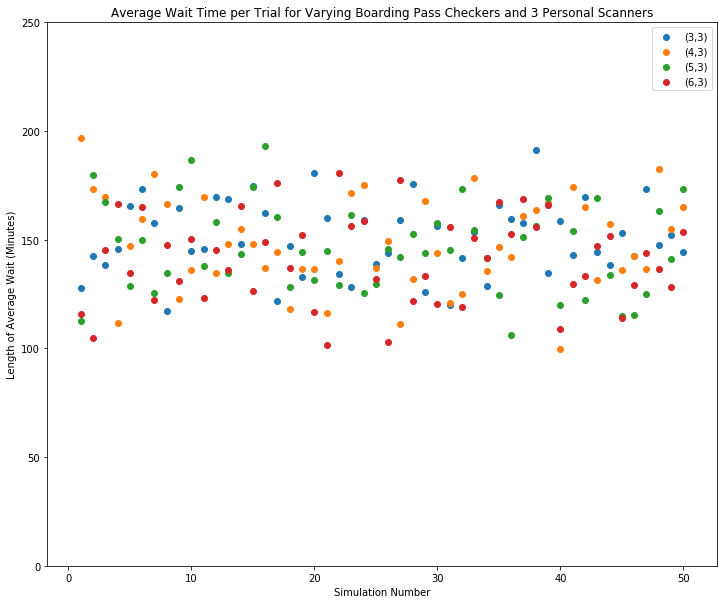

In [8]:
#Now plot all the average waits for each trial. 
plt.figure(figsize=(12,10))
plt.scatter(x=range(1,51), y=average_waits_bptrial[0])
plt.scatter(x=range(1,51), y=average_waits_bptrial[1])
plt.scatter(x=range(1,51), y=average_waits_bptrial[2])
plt.scatter(x=range(1,51), y=average_waits_bptrial[3])
plt.legend(['(3,3)', '(4,3)', '(5,3)', '(6,3)'])
plt.ylim((0,250))
plt.title('Average Wait Time per Trial for Varying Boarding Pass Checkers and 3 Personal Scanners')
plt.xlabel('Simulation Number')
plt.ylabel('Length of Average Wait (Minutes)');

And we get a very similar result to when we held the number of boarding pass checkers constant at 3. Based on this I would say the necessary number of both boarding pass checkers and personal scanner lines is 4 of each. Confirm this by re-plotting the (4,4) set again, and printing out the mean of the set.

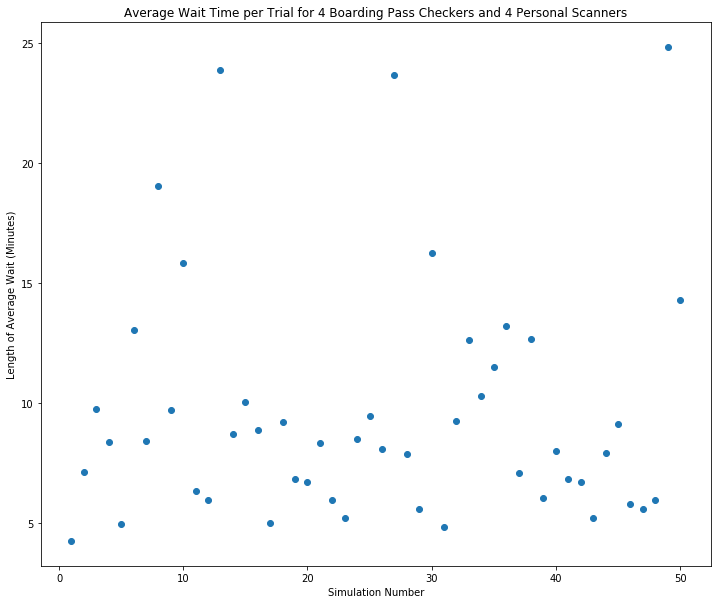

In [9]:
plt.figure(figsize=(12,10))
plt.scatter(x=range(1,51), y=average_waits[3])
plt.title('Average Wait Time per Trial for 4 Boarding Pass Checkers and 4 Personal Scanners')
plt.xlabel('Simulation Number')
plt.ylabel('Length of Average Wait (Minutes)');

In [10]:
print('Average wait time:', np.mean(average_waits[3]))

Average wait time: 9.593088292749766


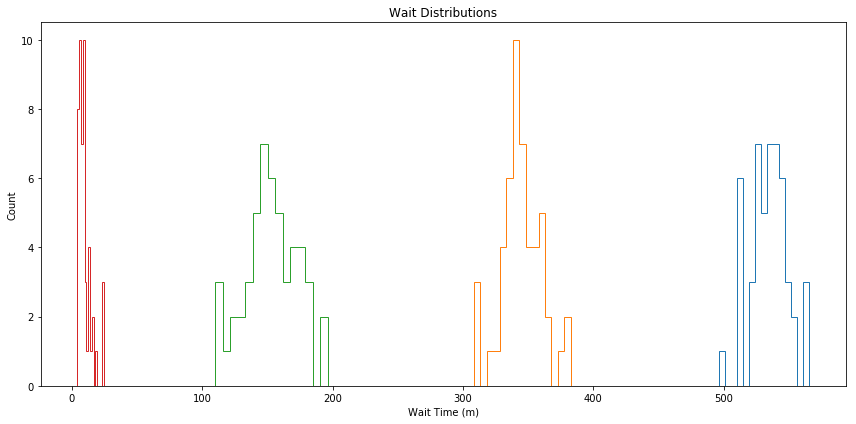

In [54]:
#Plotting the different distributions for different pairs of bag checkers/boarding pass checkers
#Step setting looks kind of neat
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
for i in range(4):
    plt.hist(average_waits[i], histtype='step', bins=15)
plt.xlabel('Wait Time (m)')
plt.ylabel('Count')
plt.title('Wait Distributions - Pairs')
plt.tight_layout()

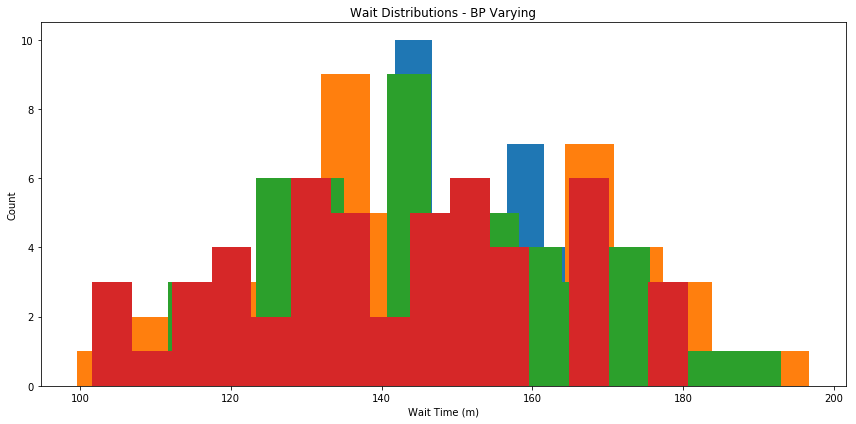

In [58]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
for i in range(4):
    plt.hist(average_waits_bptrial[i], histtype='stepfilled', bins=15)
plt.xlabel('Wait Time (m)')
plt.ylabel('Count')
plt.title('Wait Distributions - BP Varying')
plt.tight_layout()
plt.show()

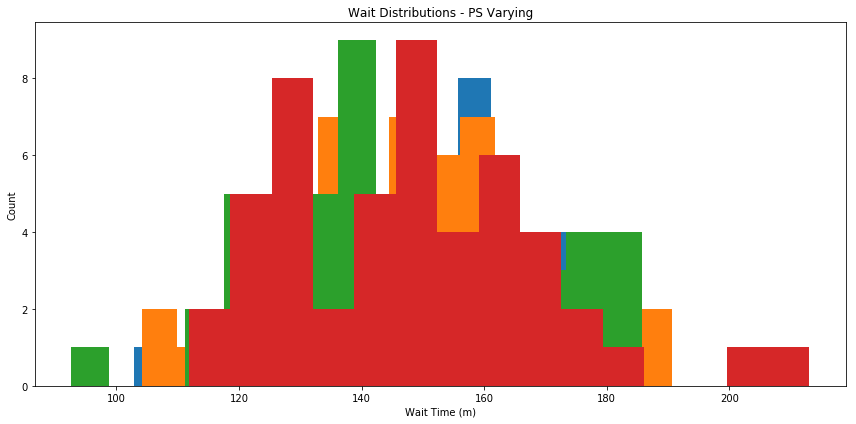

In [59]:
fig, ax = plt.subplots(ncols=1, figsize=(12,6))
for i in range(4):
    plt.hist(average_waits_personaltrial[i], histtype='stepfilled', bins=15)
plt.xlabel('Wait Time (m)')
plt.ylabel('Count')
plt.title('Wait Distributions - PS Varying')
plt.tight_layout()
plt.show()

So we can see that 4,4 is the lowest combination of checkers and personal scanners which will give an average wait time under 15 minutes. The distributions for all varying simulations clearly show a large wait time while holding either one of the parameters at 3.